#### Part 1 : Data Fetch: Import Dependencies, Read CSV and explore Data features  

- [Download Data via this link](https://www.kaggle.com/datasets/ealaxi/paysim1/download?datasetVersionNumber=2) and save into resources file : final path should be "../5.Resources/PS_20174392719_1491204439457_log.csv

- First section is set out to import all required dependencies and to read raw_csv file into dataframe 

In [102]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import csv
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [103]:
# READ IN CSV as raw_csv
raw_csv = pd.read_csv("//Users/tattwamasiray/Downloads/Monash-BOOTCAMP/Financial Fraud Analysis/Project4-Team6-Financial-Fraud-Analysis-using-Machine-Learning/5.Resources/PS_20174392719_1491204439457_log.csv")


##### Exploring existing data set:
The following section explores the raw data `raw_csv` to identify cleaning required .
- In this section we review the existing data set.

In [104]:
# Explore csv info
raw_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [105]:
## Show Summary of isFraud Type 
type_summary = pd.crosstab(raw_csv['type'], raw_csv['isFraud'])
type_summary

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [106]:
# Explore unique variables
unique_counts=raw_csv.nunique()
print(unique_counts)

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


There are a total of 6,362,620 rows and 8,213 instances of Fraud which is 0.129%.  
We have identified through column 'type' that Fraud only occured in 2 transaction types : 'CASH_OUT' and 'TRANSFER'.  
All other Types should be dropped from the model as they do not appear to have fraud in this case. 

There are 743 Steps as hours.

In [107]:
# Explore  Distribution of numerical data.
distribution_summary  = raw_csv.describe()
print(distribution_summary )

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [108]:
# Explore Distribution of Categorical Data
# Generate the distribution summary for categorical columns
categorical_summary = {}
for col in raw_csv.select_dtypes(include=['object']):
    categorical_summary[col] = raw_csv[col].value_counts()

# Display the distribution summary for categorical columns
for col, counts in categorical_summary.items():
    print(f"\nDistribution for column '{col}':")
    print(counts)



Distribution for column 'type':
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Distribution for column 'nameOrig':
nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64

Distribution for column 'nameDest':
nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64


In [109]:
# Explore if Null exists
raw_csv.isnull().values.any()

False

In [110]:
# Count the occurrences of 0 in 'oldbalanceORG'
missing_oldbalance = (raw_csv['oldbalanceOrg'] == 0).sum()

# Print the result
print(missing_oldbalance)

2102449


In [111]:
# Count the occurrences of 0 in 'amount'
missing_transaction = (raw_csv['amount'] == 0).sum()

# Print the result
print(missing_transaction)

16


#### Part 2: Data Clean and Create New Features & Digitise data

In [112]:
# Copy raw_csv and use clean_csv to clean up and add features
clean_csv_df = raw_csv.copy()

In [113]:

# Drop rows where the 'type' is 'Cash_IN', 'Debit', or 'Payment' in-place
types_to_drop = ['CASH_IN', 'DEBIT', 'PAYMENT']
clean_csv_df.drop(clean_csv_df[clean_csv_df['type'].isin(types_to_drop)].index, inplace=True)
clean_csv_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [114]:
# Drop rows where 'amount' is equal to 0
clean_csv_df = clean_csv_df[clean_csv_df['amount'] != 0]

In [115]:
# Replace 0 values in 'oldbalanceORG' column with values from 'amount' column
clean_csv_df.loc[clean_csv_df['oldbalanceOrg'] == 0, 'oldbalanceOrg'] = clean_csv_df.loc[clean_csv_df['oldbalanceOrg'] == 0, 'amount']

In [116]:
### Reset index and view data infom
clean_csv_df.reset_index(drop=True, inplace=True)
clean_csv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770393 entries, 0 to 2770392
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 232.5+ MB


In [117]:
### NEW FEATURES based on Step : Hour  Cycle and Week

## Create hour cycle to reset to 1 every 24 steps
clean_csv_df['hour'] = ((clean_csv_df['step'] - 1) % 24) + 1

## Create Cycle every 24 Hours
# Create a new column 'new_column' initialized with 1
clean_csv_df['day'] = 1

# Calculate the increments of 1 for every 24 increases in the 'step' column
clean_csv_df['day'] += (clean_csv_df['step'] - 1) // 24


# Create a new column 'week' by increasing 1 for each cycle
clean_csv_df['week'] = ((clean_csv_df['step'] - 1) // 168) + 1

# Drop the intermediate 'cycles' column if needed
# raw_csv.drop(columns=['cycles'], inplace=True)

clean_csv_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1


In [118]:
### NEW FEATURES based on old and new balance

# Create new columns for the division of 'amount' by 'oldbalanceOrg'
clean_csv_df['trans_weight'] = clean_csv_df['amount'] / clean_csv_df['oldbalanceOrg']

# % Change in Balance Transaction 
clean_csv_df['bal_change_per'] = (clean_csv_df['newbalanceOrig']-   clean_csv_df['oldbalanceOrg'])/ clean_csv_df['oldbalanceOrg']


# Create Large Transaction Figure
clean_csv_df['large_transaction'] = (clean_csv_df['amount'] > 100000).astype(int)


# Round 'trans_weight' to the nearest two decimals
clean_csv_df['trans_weight'] = clean_csv_df['trans_weight'].round(2)

# Round 'bal_change_per' to the nearest two decimals
clean_csv_df['bal_change_per'] = clean_csv_df['bal_change_per'].round(2)

clean_csv_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1,1.00,-1.0,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1


In [119]:
### NEW FEATURES Creating Dummies bases on 'type'
# Create dummy variables for the 'type' column
dummy_columns = pd.get_dummies(clean_csv_df['type'], prefix='type')

# Concatenate the dummy variables with the original DataFrame
clean_csv_df = pd.concat([clean_csv_df, dummy_columns], axis=1)

# Display the updated DataFrame with the dummy columns
clean_csv_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True


In [120]:
#######################
############# fraud_det_df
#########################
## PRINT the cleaned data to csv fraud_det_df
fraud_det_df = clean_csv_df.copy()

# Export the DataFrame as a CSV file. 
# fraud_det_df.to_csv("Resources/fraud_det_df.csv", encoding='utf8', index=False)
fraud_det_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True


In [121]:
# Copy and confirm column features
fraud_det_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour', 'day', 'week', 'trans_weight',
       'bal_change_per', 'large_transaction', 'type_CASH_OUT',
       'type_TRANSFER'],
      dtype='object')

In [122]:
#####################
## Copy dataframe to convert data for digital transformation
fraud_det_dig_df = fraud_det_df.copy()
fraud_det_dig_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True


In [123]:
# Drop 'nameOrig' and 'type' columns
fraud_det_dig_df.drop(columns=['nameOrig', 'type'], inplace=True)

In [124]:

# Digitize 'nameDest' based on categories and create the 'Destination' column
fraud_det_dig_df['Destination'] = pd.factorize(fraud_det_dig_df['nameDest'])[0]

# Print the updated DataFrame to check the result
fraud_det_dig_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,1,181.00,181.0,0.0,C553264065,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True,0
1,1,181.00,181.0,0.0,C38997010,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False,1
2,1,229133.94,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False,2
3,1,215310.30,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True,3
4,1,311685.89,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True,4


In [125]:
# Drop nameDest as has been factorised
fraud_det_dig_df.drop(columns=['nameDest'], inplace=True)


In [126]:
#######################
############# fraud_det_dig_df
#########################
# View summary of digitised dataframe for model
fraud_det_dig_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,1,181.00,181.0,0.0,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True,0
1,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False,1
2,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False,2
3,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True,3
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True,4


#### Part 3 : Data Summary and Visualisation

In [127]:
## Validate that no Null values have carried through.
null_values_count = fraud_det_df.isnull().sum()
null_values_count

step                 0
type                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
hour                 0
day                  0
week                 0
trans_weight         0
bal_change_per       0
large_transaction    0
type_CASH_OUT        0
type_TRANSFER        0
dtype: int64

In [128]:
fraud_det_df['hour'] = ((fraud_det_df['step'] - 1) % 24) + 1


In [129]:
## Show Summary of isFraud Type 
type_summary = pd.crosstab(fraud_det_df['type'], fraud_det_df['isFraud'])
type_summary

isFraud,0,1
type,,
CASH_OUT,2233384,4100
TRANSFER,528812,4097


In [130]:
## Show Summary of isFraud Type 
type_summary = pd.crosstab(fraud_det_df['type'], fraud_det_df['isFlaggedFraud'])
type_summary

isFlaggedFraud,0,1
type,,
CASH_OUT,2237484,0
TRANSFER,532893,16


In [131]:
## Show Summary of isFraud hour 
hour_summary = pd.crosstab(fraud_det_df['hour'], fraud_det_df['isFraud'])
hour_summary

isFraud,0,1
hour,,
1,5647,358
2,1550,371
3,454,325
4,238,274
5,266,366
6,546,357
7,2214,328
8,9934,368
9,119687,341


In [132]:
# Create a new column 'week' by increasing 1 for each cycle
clean_csv_df['week'] = ((clean_csv_df['step'] - 1) // 168) + 1


In [133]:
# Show Summary of isFraud Week
week_summary = pd.crosstab(clean_csv_df['week'], clean_csv_df['isFraud'])
week_summary


isFraud,0,1
week,,
1,845892,1904
2,1241288,1860
3,553562,1851
4,93608,1786
5,27846,796


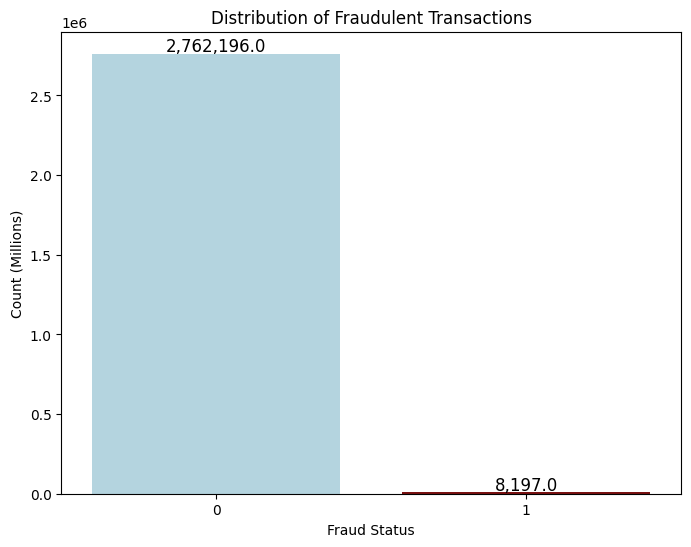

isFraud
0    2762196
1       8197
Name: count, dtype: int64


In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming fraud_det_df is your DataFrame
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
# Define custom colors for the bars
custom_palette = {0: 'lightblue', 1: 'darkred'}
ax = sns.countplot(data=fraud_det_df, x='isFraud', palette=custom_palette)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions")
plt.xlabel("Fraud Status")
plt.ylabel("Count (Millions)")
plt.show()

# Print the count of each fraud status
count_fraud = fraud_det_df['isFraud'].value_counts()
print(count_fraud)


Exploratory Data Analysis and EDA and Fraud detection

The provided data has the financial transaction data as well as the target variable isFraud, which is the actual fraud status of the transaction and isFlaggedFraud is the indicator which the simulation is used to flag the transaction using some threshold.

The goal should be how we can improve and come up with better threshold to capture the fraud transaction.

In this visualization, we took a smaller random sample of 1000 transactions from the original dataset to make it easier to visualize. Then, we created three side-by-side histograms, one for each numeric feature ('amount', 'oldbalanceOrg', 'newbalanceOrig'), showing the distribution of these values to help understand how the data is spread out.

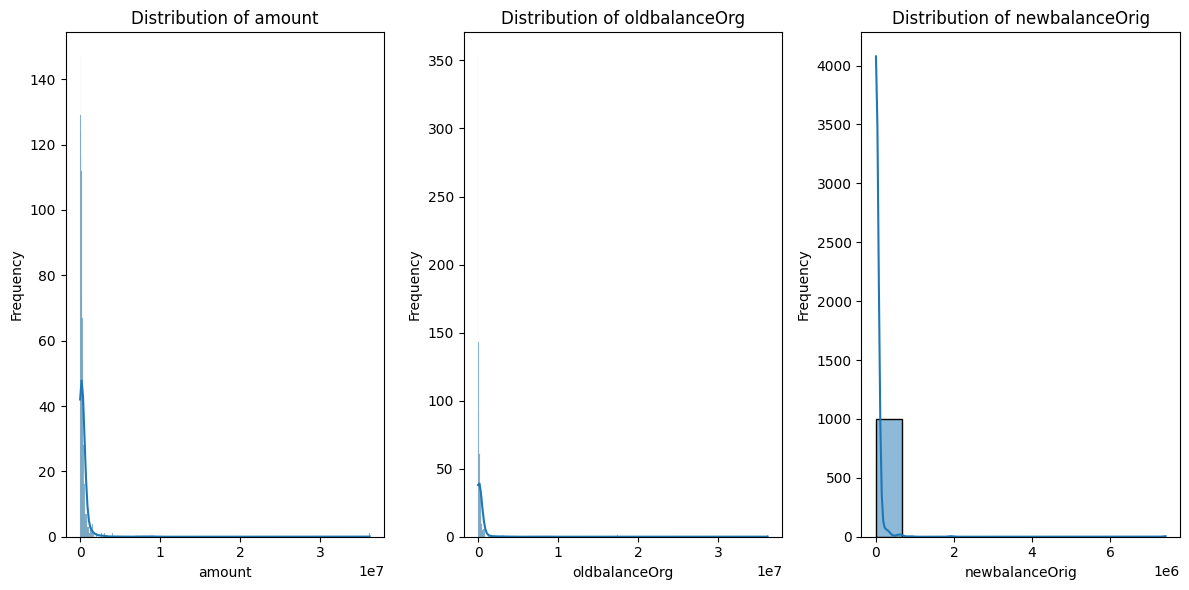

In [135]:
# These are the numerical features in your dataset
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
sampled_data = fraud_det_df.sample(n=1000)  

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    sns.histplot(data=sampled_data, x=feature, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [136]:
print(fraud_det_df.columns)  # Print all column names
print(fraud_det_df['day'].unique())  # Print unique values in the 'day' column


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour', 'day', 'week', 'trans_weight',
       'bal_change_per', 'large_transaction', 'type_CASH_OUT',
       'type_TRANSFER'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


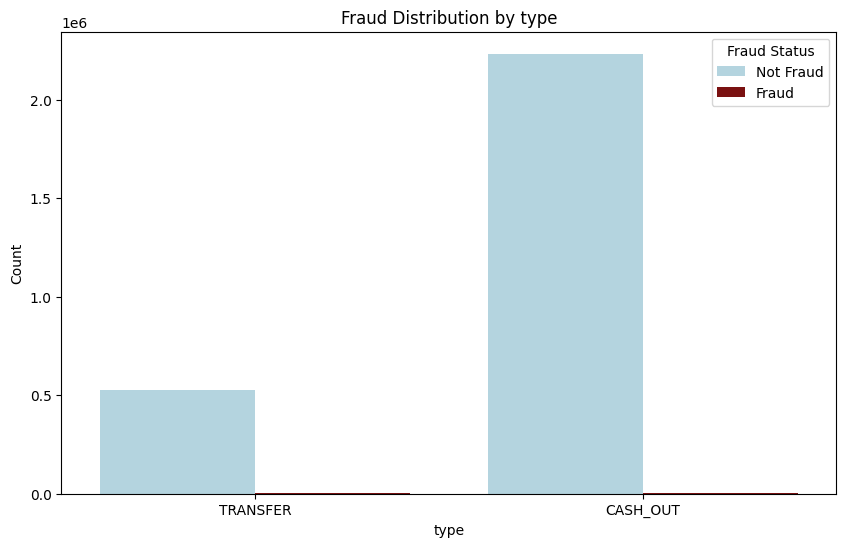

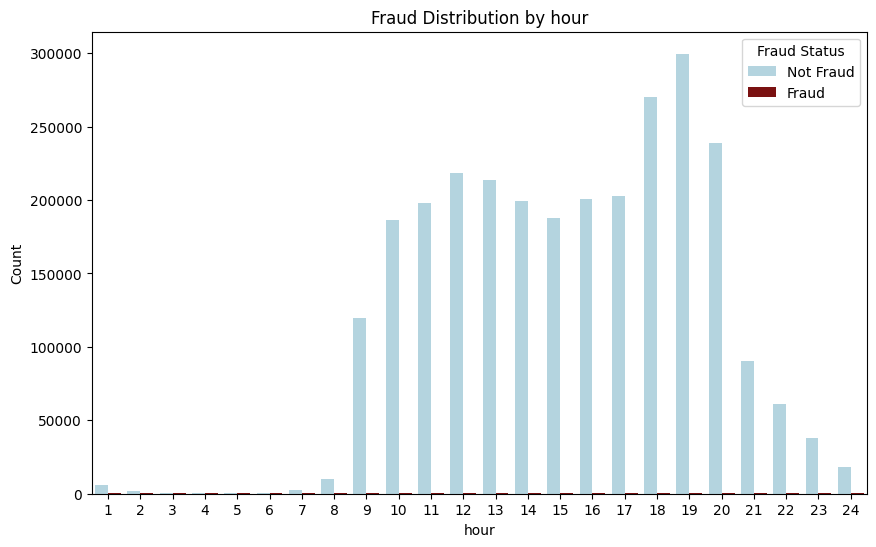

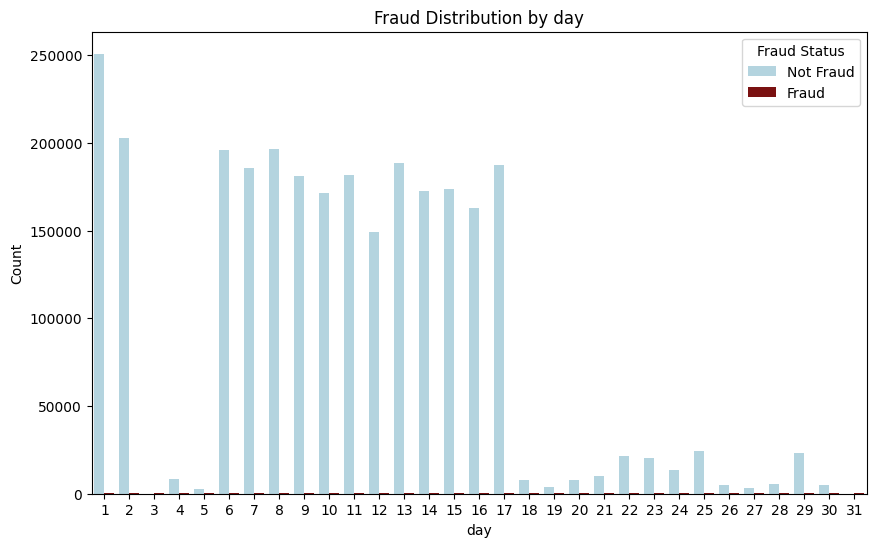

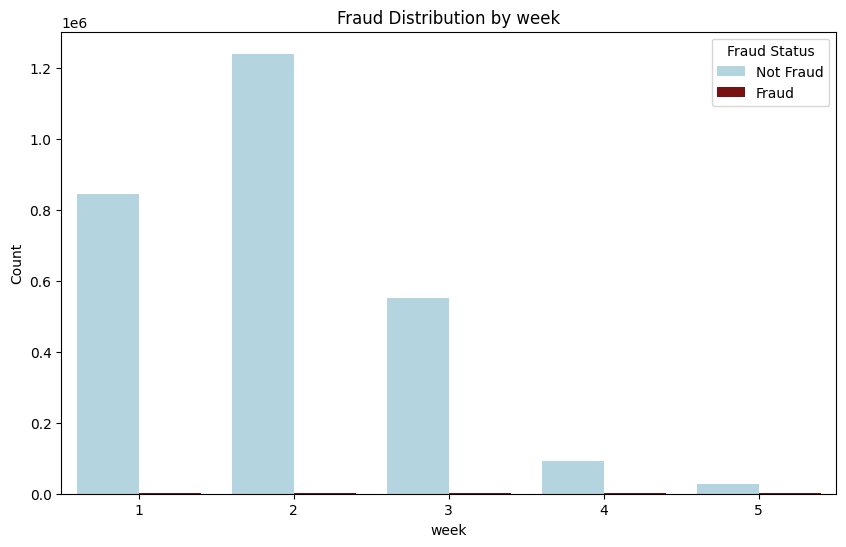

In [137]:
# Bivariate Analysis of Categorical Features and 'isFraud'
# Define custom colors for the hue (0: Not Fraud, 1: Fraud)
custom_palette = {0: 'lightblue', 1: 'darkred'}

categorical_features = ['type', 'hour', 'day', 'week']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fraud_det_df, x=feature, hue='isFraud', palette=custom_palette)
    plt.title(f"Fraud Distribution by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title='Fraud Status', labels=['Not Fraud', 'Fraud'])
    plt.show()


The above visualizations helps us compare the occurrence of fraud between different categories of categorical features. By visually examining the distribution of fraudulent and non-fraudulent transactions, we can identify patterns and trends related to fraud occurrence in specific scenarios, such as transaction types, hours, days, or weeks. These insights enable fraud investigators to focus their efforts on high-risk categories and implement targeted fraud prevention strategies.

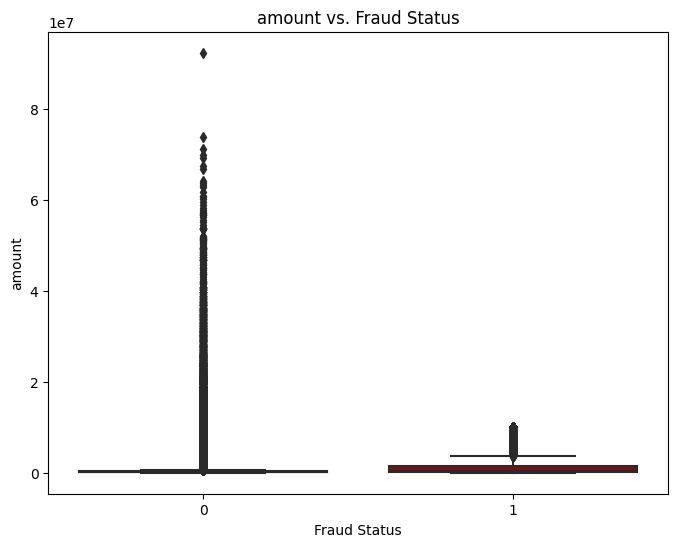

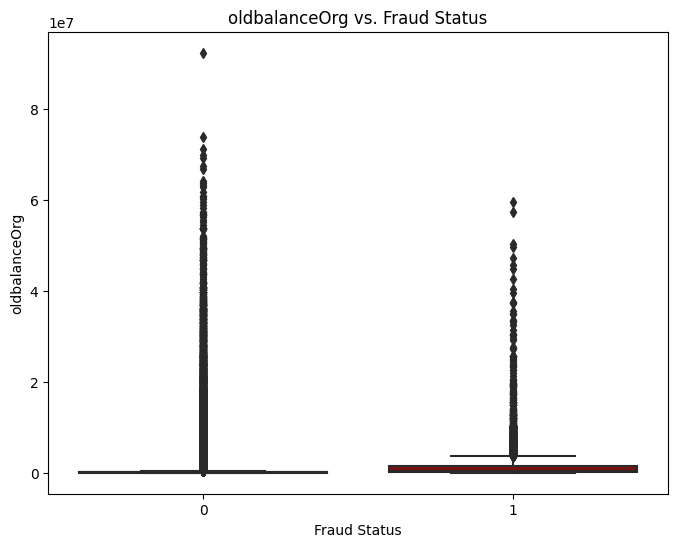

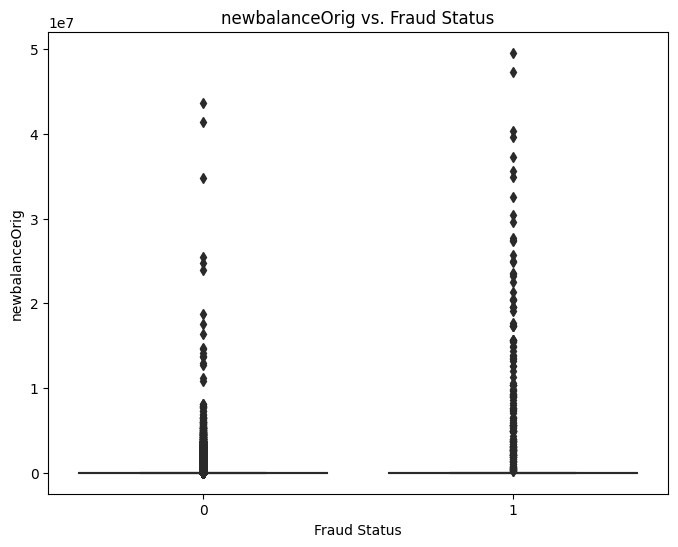

In [138]:
# Bivariate Analysis of Numeric Features and 'isFraud'

# Define custom colors for the hue (0: Not Fraud, 1: Fraud)
custom_palette = {0: 'lightblue', 1: 'darkred'}

numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=fraud_det_df, x='isFraud', y=feature, palette=custom_palette)
    plt.title(f"{feature} vs. Fraud Status")
    plt.xlabel("Fraud Status")
    plt.ylabel(feature)
    plt.show()


We use bivariate analysis using box plots provides valuable insights into the distribution of numeric features based on fraud status. This information helps in designing more effective fraud detection strategies and improving the accuracy of detecting fraudulent transactions.

In [139]:
# # Outlier detection 
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Numeric features for outlier detection
# numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

# # Create box plots for numeric features
# plt.figure(figsize=(12, 6))
# for i, feature in enumerate(numeric_features, 1):
#     plt.subplot(1, len(numeric_features), i)
#     sns.boxplot(data=fraud_det_df, x=feature)
#     plt.title(f"Box Plot of {feature}")
#     plt.xlabel(feature)
# plt.tight_layout()
# plt.show()


#### Part 4: Print CSV for Data Model

In [140]:
## Print fraud_det_df which is first working data frame
### Data is not digitised and still contains dummies

# fraud_det_df.to_csv("Resources/fraud_det.csv", index=False)

In [141]:
# Print fraud_det__dig_df which is first working data frame
### Data is not digitised and still contains dummies
fraud_det_dig_df.to_csv("../5.Resources/fraud_det_dig_df.csv", index=False)

In [142]:
# view summary of data to use for model - final data frame
fraud_det_dig_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,1,181.00,181.0,0.0,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,False,True,0
1,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,True,False,1
2,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,True,False,2
3,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,False,True,3
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,False,True,4


#### Part 5 : Addresing Class Imbalance

In [143]:
# Read in the data frame for the model "fraud_det_dig_df"
raw_df = pd.read_csv("../5.Resources/fraud_det_dig_df.csv")

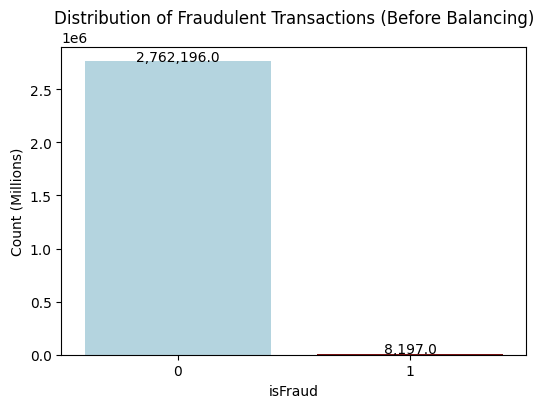

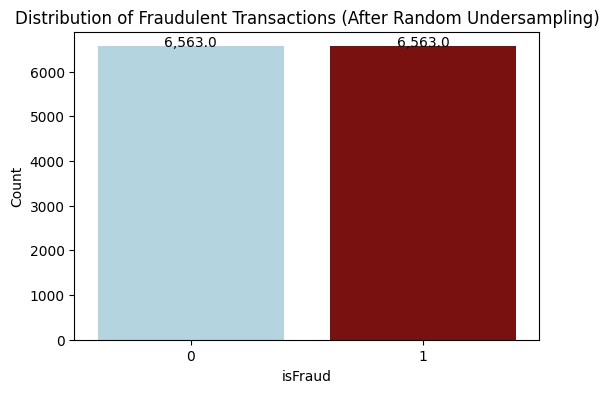

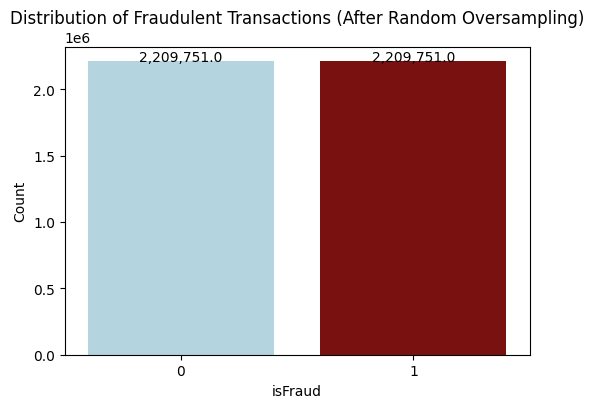

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Define custom colors for the hue (0: Not Fraud, 1: Fraud)
custom_palette = {0: 'lightblue', 1: 'darkred'}

# Visualize the distribution of 'isFraud' before balancing
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=raw_df, x='isFraud', palette=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (Before Balancing)")
plt.xlabel("isFraud")
plt.ylabel("Count (Millions)")
plt.show()

## DEFINE target Class and set X variables
# Separate features and target variable
X = raw_df.drop('isFraud', axis=1)
y = raw_df['isFraud']

# Perform train-test split on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Visualize the distribution of 'isFraud' after Random Undersampling
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y_rus, palette=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (After Random Undersampling)")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

# Perform Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Visualize the distribution of 'isFraud' after Random Oversampling
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y_ros, palette=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (After Random Oversampling)")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


### Data Fetch for Tableau Visualisation
Fetch Data for TABLEAU Visualisation - minimise and aggregate where possible

In [145]:
tableau_df = pd.read_csv("../5.Resources/PS_20174392719_1491204439457_log.csv")
tableau_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [146]:
# Recreate time and hour features
tableau_df['hour'] = ((tableau_df['step'] - 1) % 24) + 1

## Create Cycle every 24 Hours
# Create a new column 'new_column' initialized with 1
tableau_df['day'] = 1

# Calculate the increments of 1 for every 24 increases in the 'step' column
tableau_df['day'] += (tableau_df['step'] - 1) // 24

# Create a new column 'week' by increasing 1 for each cycle
tableau_df['week'] = ((tableau_df['step'] - 1) // 168) + 1

tableau_df['time'] = (tableau_df['hour'] - 1).apply(lambda x: f"{x % 12 + 1}:00 {'AM' if x < 12 else 'PM'}")
tableau_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,time
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,1,1:00 AM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,1,1:00 AM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1,1:00 AM
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,1,1:00 AM
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,1,1:00 AM


In [147]:
# Extract the hour component from the 'time' column and convert it to a numerical value
tableau_df['hour'] = tableau_df['time'].str.extract(r'(\d+):').astype(int)

# Now you can use the 'hour' column as a numerical feature


In [148]:
## Dtop columns not to use for summary
columns_to_drop = ['step', 'hour', 'isFlaggedFraud']
tableau_df.drop(columns_to_drop, axis=1, inplace=True)
tableau_df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day,week,time
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1,1,1:00 AM
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1,1,1:00 AM
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,1,1,1:00 AM
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,1,1,1:00 AM
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1,1,1:00 AM


In [149]:
# AGGFREGATE DATA SUM
# Grouping by the specified columns and calculating the sum of 'amount' and 'oldbalanceOrg'
agg_sum_df = tableau_df.groupby(['type', 'isFraud', 'time', 'day', 'week']).agg({
    'amount': 'sum',
    'oldbalanceOrg': 'sum',
    'nameOrig': 'count'  # Calculates the count of 'nameOrig'
}).reset_index()

agg_sum_df.head()


agg_sum_df.to_csv("../5.Resources/tableau_agg_sum.csv", index=False)


In [150]:
## Create specialised Dataframe summary  

# Grouping by 'type' and 'isFraud' and aggregating the required statistics
agg_unique_df = tableau_df.groupby(['type', 'isFraud']).agg({
    'amount': ['mean', 'max', 'min'],
    'nameDest': pd.Series.nunique,
    'nameOrig': pd.Series.nunique  # Calculates the count of unique 'nameDest'
}).reset_index()

# Rename the columns for clarity
agg_unique_df.columns = ['type', 'isFraud', 'average_amount', 'max_amount', 'min_amount', 'unique_recipient','unique_customer']
agg_unique_df.to_csv("../5.Resources/tableau_agg_unique.csv", index=False)
